In [1]:
from jax import config
import jax.numpy as np
import webbpsf
import matplotlib.pyplot as plt
import dLux as dl
from optics import NIRISSOptics, find_wavelengths, find_diameter

config.update("jax_enable_x64", True)
plt.rcParams["image.origin"] = 'lower'

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


# NIRISS dLux Model - Ignoring Detector Effects
First lets model the PSFs ignoring detector effects. We will consider only the aperture and the field dependent aberrations.

## Model PSF from WebbPSF

In [2]:
# creating NIRISS object
NIRISS = webbpsf.NIRISS()

# updating NIRISS configuration
NIRISS.filter = 'F480M'
NIRISS.pupil_mask = 'MASK_NRM'
psfs = NIRISS.calc_psf()  # calculating fits files
webbpsfpsf = psfs[0].data  # PSF Array from WebbPSF

In [13]:
NIRISS._detector_geom_info.aperture

<pysiaf.Aperture object AperName=NIS_CEN >

## Model PSF from dLux

In [3]:
# Grabbing from WebbPSF
AMI_mask = np.array(NIRISS.optsys.planes[3].amplitude)  # transmission array of AMI Mask
diameter = find_diameter(NIRISS.optsys)  # finding JWST diameter
# hardcoded by WebbPSF for a genius reason
det_npix = 304
oversample = 4

# aperture aberrations
aperture = dl.Optic(transmission=NIRISS.optsys.planes[0].amplitude,
                    opd=NIRISS.optsys.planes[0].opd,
                    normalise=True
                    )

# flat detector aberrations
FDA = dl.Optic(transmission=NIRISS.optsys.planes[2].amplitude,
               opd=NIRISS.optsys.planes[2].opd,
               )

# creating dLux optics
optics = NIRISSOptics(aperture=aperture,
                      FDA=FDA,
                      pupil_mask=AMI_mask,
                      psf_npixels=det_npix,
                      psf_oversample=oversample,
                      )

# Generating PSF with dLux
wavels, weights = find_wavelengths(psfs[0])  # finding wavelengths and spectral weights
dluxpsf = optics.propagate(np.array(wavels), weights=np.array(weights))

## Comparing PSFs
As you can see, they match to machine precision.

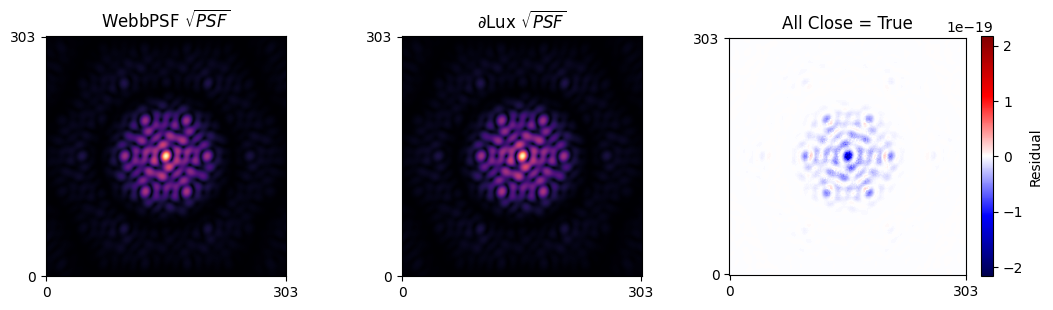

In [4]:
# plotting
fig, ax = plt.subplots(1, 3, figsize=(10.5, 4))
fig.subplots_adjust(left=0.02, right=0.98, top=0.8, bottom=0.2)
ticks = [0, webbpsfpsf.shape[0]-1]
# WebbPSF PSF
c0 = ax[0].imshow(webbpsfpsf**.5, cmap='magma')
ax[0].set(title='WebbPSF $\sqrt{PSF}$', xticks=ticks, yticks=ticks)
# fig.colorbar(c0, label='Relative Intensity')

# dLux PSF
c1 = ax[1].imshow(dluxpsf**.5, cmap='magma')
ax[1].set(title=r'$\partial$Lux $\sqrt{PSF}$', xticks=ticks, yticks=ticks)
# fig.colorbar(c1, label='Relative Intensity')

# Residuals
residuals = webbpsfpsf - dluxpsf
bounds = np.array([-residuals.min(), residuals.max()])
c2 = ax[2].imshow(residuals, cmap='seismic',
                  vmin=-bounds.max(), vmax=bounds.max())
ax[2].set(title=f'All Close = {np.allclose(webbpsfpsf, dluxpsf)}', xticks=ticks, yticks=ticks)
fig.colorbar(c2, label='Residual')

plt.show()

# NIRISS dLux Model - Including Detector Effects
## WebbPSF
Using `psfs[2]` now...

In [5]:
webbpsfdetpsf = psfs[2].data  # PSF Array from WebbPSF

## dLux

In [6]:
from layers import DistortionFromSiaf, ApplyBFE
from dLux.utils import deg_to_rad as d2r

In [7]:
baseline = 0.
NIS_CEN_aperture = NIRISS.siaf.apertures['NIS_CEN']

# Construct Detector
detector = dl.LayeredDetector([
    dl.ApplyJitter(sigma=1.5),  # Gaussian Jitter
    dl.detector_layers.RotateDetector(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),  # Rotates PSF by half a degree
    DistortionFromSiaf(aperture=NIS_CEN_aperture, oversample=oversample),  # Wavefront sphere to wavefront plane TODO fix ValueError: Expected tuple, got 0.0.
    # dl.IntegerDownsample(kernel_size=oversample),  # Downsample to detector pixel scale
    # ApplyBFE(1e-6),  # Apply BFE TODO fix 'Image' object has no attribute 'shape'
    dl.AddConstant(baseline),  # Add baseline
])

source = dl.PointSource(wavelengths=wavels, weights=weights)
instrument = dl.Instrument(optics=optics, sources=source, detector=detector)

dluxdetpsf = instrument.model()

TypeError: Unexpected input type for array: <class 'dLux.images.Image'>

In [27]:
# Construct Detector
detector2 = dl.LayeredDetector([
    # dl.ApplyJitter(sigma=1.5),
    # dl.detector_layers.RotateDetector(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),
    # DistortionFromSiaf(aperture=NIS_CEN_aperture, oversample=oversample),
    # dl.IntegerDownsample(kernel_size=oversample),
    # ApplyBFE(1e-6),
    # dl.AddConstant(baseline),
])

instrument2 = dl.Instrument(optics=optics, sources=source, detector=detector2)

webbpsfdetpsf = instrument2.model()

TypeError: sub got incompatible shapes for broadcasting: (304, 304), (76, 76).

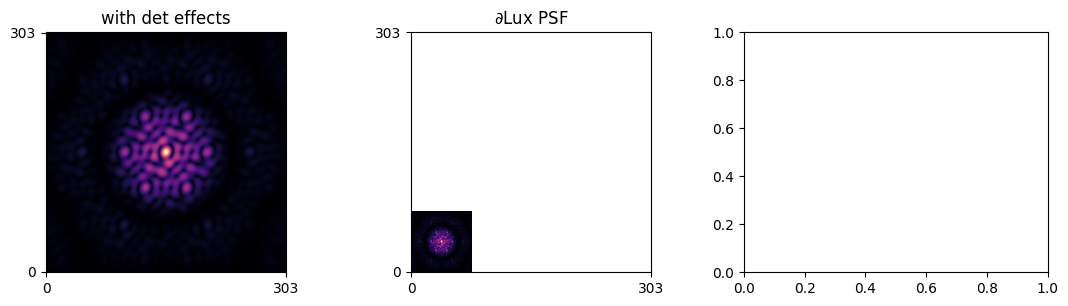

In [31]:
# plotting
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
fig.subplots_adjust(left=0.03, right=0.97, top=0.8, bottom=0.2)

# WebbPSF PSF
c0 = ax[0].imshow(webbpsfdetpsf**.5, cmap='magma')
ax[0].set(title='WebbPSF $\sqrt{PSF}$', xticks=ticks, yticks=ticks)
ax[0].set(title='with det effects', xticks=ticks, yticks=ticks)
# fig.colorbar(c0, label='Relative Intensity')

# dLux PSF
c1 = ax[1].imshow(dluxdetpsf**.5, cmap='magma')
ax[1].set(title=r'$\partial$Lux PSF', xticks=ticks, yticks=ticks)
# fig.colorbar(c1, label='Relative Intensity')

# Residuals
residuals = webbpsfdetpsf - dluxdetpsf
bounds = np.array([-residuals.min(), residuals.max()])
c2 = ax[2].imshow(residuals, cmap='seismic',
                  vmin=-bounds.max(), vmax=bounds.max())
ax[2].set(title=f'All Close = {np.allclose(webbpsfdetpsf, dluxdetpsf)}')
fig.colorbar(c2, label='Residual')

plt.show()